<a href="https://colab.research.google.com/github/HwangHanJae/ml-definitive-guide-pratice/blob/main/regression/regression_training_bike_sharing_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 회귀 실습 - 자전거 대여 수요 예측
- 캐글의 자전거 대여 수요(Bike sharing Demand) 예측 경연에서 사용된 학습데이터 이용


데이터의 주요 칼럼
- datetime : hourly date + timestamp
- season : 1=봄, 2=여름, 3=가을, 4=겨울
- holiday : 1=토, 일요일의 주말을 제외한 국경일 등의 휴일, 0=휴일이 아닌날
- workingday : 1=토, 일요일의 주말을 및 휴일이 아닌 주중, 0=주말 및 휴일
- weather : 
  - 1 = 맑음, 약간 구름 낀 흐림
  - 2 = 안개, 안개 + 흐림
  - 3 = 가벼운 눈, 가벼운 비 + 천둥
  - 4 = 심한눈/비, 천둥/번개
- temp : 온도(섭씨)
- atemp : 체감온도(섭씨)
- windspeed : 풍속
- casual : 사전에 등록되지 않는 사용자가 대여한 횟수
- registered : 사전에 등록된 사용자가 대여한 횟수
- count : 대여횟수

라이브러리 로드

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')


In [82]:
train_path="/content/drive/MyDrive/Colab Notebooks/DataScience/Data/bike-sharing-demand/train.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/bike-sharing-demand/test.csv"
sub_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/bike-sharing-demand/sampleSubmission.csv"

In [83]:
df = pd.read_csv(train_path)
print(df.shape)
df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


데이터는 10886개의 레코드와 12개의 칼럼으로 구성되어 있음

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


## 데이터 전처리

데이터의 구성을 확인해보면 Null값은 없고,   
숫자형 11개(float64 - 3, int64 - 8), datetime 칼럼만 object형

In [85]:
#datetime 컬럼을 년, 월, 일, 시간 칼럼으로 추출하는 함수

def get_date(df):
  df['year'] = pd.to_datetime(df['datetime']).dt.year
  df['month']= pd.to_datetime(df['datetime']).dt.month
  df['day'] = pd.to_datetime(df['datetime']).dt.day
  df['hour'] = pd.to_datetime(df['datetime']).dt.hour
  return df

In [86]:
df =get_date(df)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


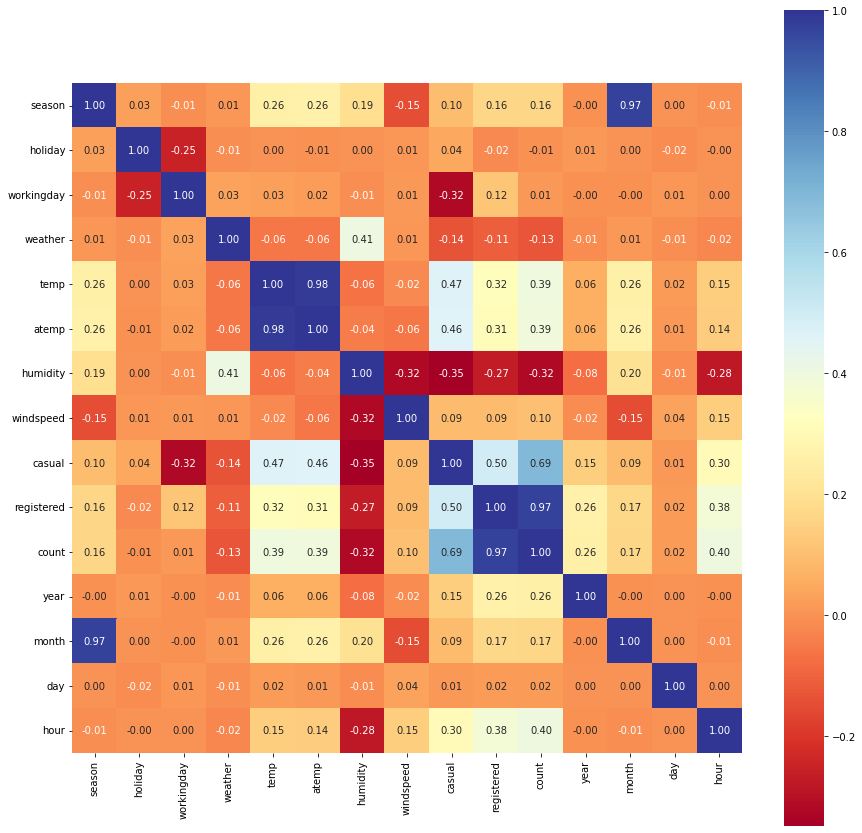

In [87]:
# 각 칼럼병 상관관계 확인
plt.figure(figsize=(15,15))
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, fmt='.2f',cmap='RdYlBu', square=True)
plt.show()

count와 casual, registered 컬럼이 높은 상관관계를 보이며,  
month와 season, temp와 atemp 컬럼이 높은 상관관계를 보이기 때문에 다중공선성의 가능성이 굉장히 높다.

따라서 casual, registered, season, temp 컬럼을 제거함

In [88]:
def drop_column(df):
  columns = ['datetime', 'casual','registered','season','temp']
  df = df.drop(columns, axis=1)
  return df

In [89]:
df = drop_column(df)
df.head()

,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,day,hour
0,0,0,1,14.395,81,0.0,16,2011,1,1,0
1,0,0,1,13.635,80,0.0,40,2011,1,1,1
2,0,0,1,13.635,80,0.0,32,2011,1,1,2
3,0,0,1,14.395,75,0.0,13,2011,1,1,3
4,0,0,1,14.395,75,0.0,1,2011,1,1,4


캐글에서 요구한 RMSLE 평가 지표는 사이킷런에서 제공하고 있지 않기 때문에  
직접 함수로 만들어 사용

In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#log 값 변환시 NaN등의 이슈로 인해 log()가 아닌 log1p()를 이용함
def rmsle(y_true, y_pred):
  log_true = np.log1p(y_true)
  log_pred = np.log1p(y_pred)
  squared_error = (log_true - log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# rmse 함수 
def rmse(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  return rmse

#rmsle, rmse,mse, mae 평가지표를 한번에 수행하고 출력하는 함수
def get_reg_eval(y_true, y_pred):
  rmsle_val = rmsle(y_true,y_pred)
  rmse_val =rmse(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)

  print("RMSLE : {:.3f}, RMSE : {:.3f}, MSE : {:.3f}, MAE : {:.3f}".format(rmsle_val, rmse_val, mse, mae))


rmsle 함수를 만들때 사이킷런의 mean_squared_log_error()를 이용할 수 있지만, 데이터 값의 크기에 따라 오버플로/언더플로 오류가 발생하기 쉽다.  

log()보다 log1p()를 사용한데, log1p() 같은 겨웅에은 1 + log() 값으로 log() 변환값에 1을 더하므로 이런 문제를 해결한다.

log1p()로 변환한 값은 expm1()으로 원래 스케일로 복원할 수 있다.

## 로그변환, 피처 인코딩

결과값(count)가 정규분포로 되어있는 확인하고, 회귀 모델의 경우 원-핫 인코딩으로 피처를 인코딩

In [91]:
#먼저 Linear Regression으로 예측을 수행하고 평가를 진행
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

X = df.drop("count", axis=1)
y = df['count']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()

models = [lr, ridge, lasso, elastic]
for model in models:
  print(f"#### {model.__class__.__name__} ####")
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  get_reg_eval(y_test, y_pred)

#### LinearRegression ####
RMSLE : 1.163, RMSE : 140.850, MSE : 19838.838, MAE : 105.874
#### Ridge ####
RMSLE : 1.163, RMSE : 140.851, MSE : 19838.902, MAE : 105.873
#### Lasso ####
RMSLE : 1.163, RMSE : 140.842, MSE : 19836.377, MAE : 105.528
#### ElasticNet ####
RMSLE : 1.174, RMSE : 143.793, MSE : 20676.556, MAE : 106.506


실제 target 데이터 값인 count를 감안하면 예측 오류로 비교적 큰 값임  

In [92]:
#실제값과 예측 값이 어느 정도 차이가 나는지 DataFrame의 칼럼으로 만들어서 오류 값이 가장 큰 순으로 5개만 확인
def get_top_error_data(y_test, pred, n_tops=5):
  #DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성.
  result_df = pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predict_count'] = np.round(pred)
  result_df['diff'] = np.abs(result_df['real_count'] - result_df['predict_count'])

  #예측값과 실제 값이 가장 큰 ㄷ게이터 순으로 출력
  print(result_df.sort_values('diff', ascending=False,)[:n_tops])

In [93]:
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
get_top_error_data(y_test, pred)

      real_count  predict_count   diff
1618         890          326.0  564.0
966          884          330.0  554.0
3151         798          249.0  549.0
2277         813          267.0  546.0
412          745          199.0  546.0


회귀에서 이렇게 큰 예측 오류가 발생할 경우 target값의 분포가 정규분포인지 확인해야 한다.  
target값의 분포가 정규분포로 되어있어야 예측 성능이 좋기 때문이다.  

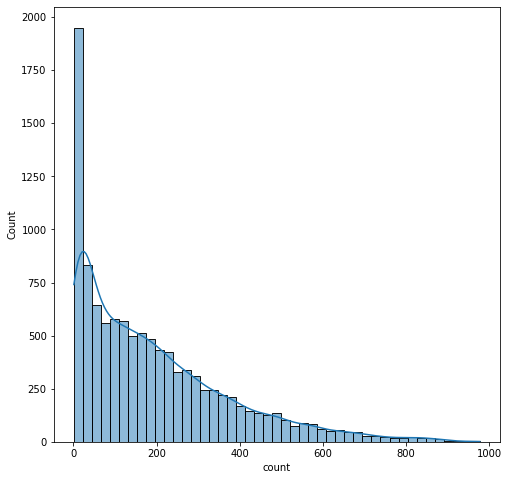

In [94]:
plt.figure(figsize=(8,8))
sns.histplot(data=df, x='count', kde=True)
plt.show()

count 칼럼의 값이 정규분포가 아니라 0 ~ 200사이의 값으로 왜곡되어 있는 것을 알 수 있음  

In [95]:
#np.log1p를 사용하여 정규분포로 만들기
def get_normal(df, column):
  df[column] = np.log1p(df[column])
  return df

In [96]:
df = get_normal(df, 'count')

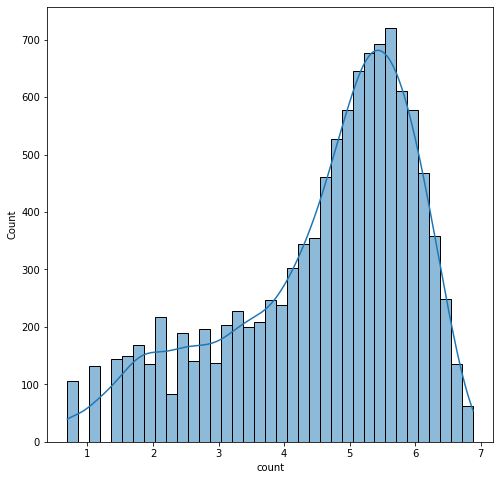

In [97]:
plt.figure(figsize=(8,8))
sns.histplot(data=df, x='count', kde=True)
plt.show()

완벽한 정규분포는 아니지만 변환하기 전보다는 왜곡 정도가 향상 되었음

In [98]:
df['count'] = np.expm1(df['count'])

In [99]:
X = df.drop('count', axis=1)
y = np.log1p(df['count'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()

y_test = np.expm1(y_test)

models = [lr, ridge, lasso, elastic]
for model in models:
  print(f"#### {model.__class__.__name__} ####")
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred = np.expm1(y_pred)
  get_reg_eval(y_test, y_pred)


#### LinearRegression ####
RMSLE : 1.017, RMSE : 162.620, MSE : 26445.234, MAE : 109.227
#### Ridge ####
RMSLE : 1.017, RMSE : 162.619, MSE : 26444.941, MAE : 109.226
#### Lasso ####
RMSLE : 1.071, RMSE : 169.461, MSE : 28716.867, MAE : 112.765
#### ElasticNet ####
RMSLE : 1.053, RMSE : 167.565, MSE : 28077.929, MAE : 111.868


RMSLE의 오류는 줄었지만 rmse는 오히려 늘어남  

회귀 계수를 값을 시각화 해보겠음

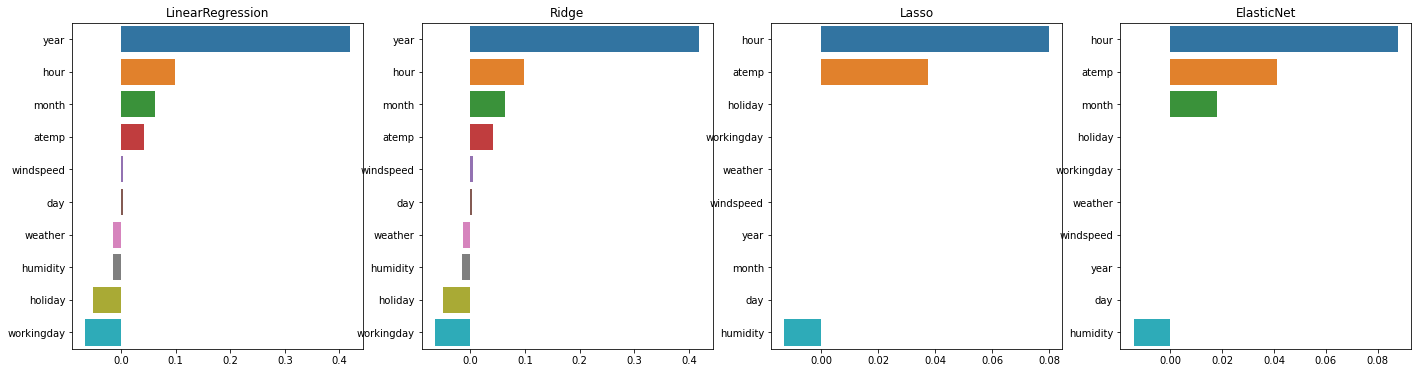

In [100]:
f, ax = plt.subplots(1,4,figsize=(24,6))
models = [lr, ridge, lasso, elastic]
for i, model in enumerate(models):
  coef = pd.Series(model.coef_, index=X.columns)
  coef = coef.sort_values(ascending=False)
  ax[i].set_title(model.__class__.__name__)
  sns.barplot(x=coef.values, y=coef.index, ax=ax[i])
  
plt.show()

year 칼럼의 회귀 계수값이 독보적으로 높음, year은 2011, 2012 두 개의 값으로 되어 있음  
회귀에서 숫자형으로 된 카테고리형 피처일 경우에는  
숫자 자체에 영향을 크게 받는 경우가 발생할 수 있기 때문에 원-핫 인코딩을 해주어야 안정적으로 예측을 할 수 있음

In [101]:
df.head()

,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,day,hour
0,0,0,1,14.395,81,0.0,16.0,2011,1,1,0
1,0,0,1,13.635,80,0.0,40.0,2011,1,1,1
2,0,0,1,13.635,80,0.0,32.0,2011,1,1,2
3,0,0,1,14.395,75,0.0,13.0,2011,1,1,3
4,0,0,1,14.395,75,0.0,1.0,2011,1,1,4


In [102]:
def one_hot_encoding(df, columns):
  df = pd.get_dummies(df, columns=columns)
  return df

columns = ['holiday', 'workingday','weather','year','month','day','hour']
df = one_hot_encoding(df, columns)

In [103]:
df.head()

,atemp,humidity,windspeed,count,holiday_0,holiday_1,workingday_0,workingday_1,weather_1,weather_2,weather_3,weather_4,year_2011,year_2012,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,14.395,81,0.0,16.0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13.635,80,0.0,40.0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13.635,80,0.0,32.0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14.395,75,0.0,13.0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,14.395,75,0.0,1.0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [104]:
# 모델과 학습/테스트 데이터를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, y_train, X_test, y_test, log=False):
  model.fit(X_train, y_train)
  pred= model.predict(X_test)
  if log:
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print(f"#### {model.__class__.__name__} ####")
  get_reg_eval(y_test, pred)

In [105]:
#원 핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측/평가 수행

X = df.drop('count', axis=1)
y = np.log1p(df['count'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
for model in models:
  get_model_predict(model, X_train, y_train, X_test, y_test, log=True)


#### LinearRegression ####
RMSLE : 0.590, RMSE : 97.514, MSE : 9508.922, MAE : 63.336
#### Ridge ####
RMSLE : 0.590, RMSE : 97.545, MSE : 9514.991, MAE : 63.357
#### Lasso ####
RMSLE : 1.240, RMSE : 177.722, MSE : 31584.959, MAE : 121.342
#### ElasticNet ####
RMSLE : 1.234, RMSE : 175.772, MSE : 30895.805, MAE : 120.290


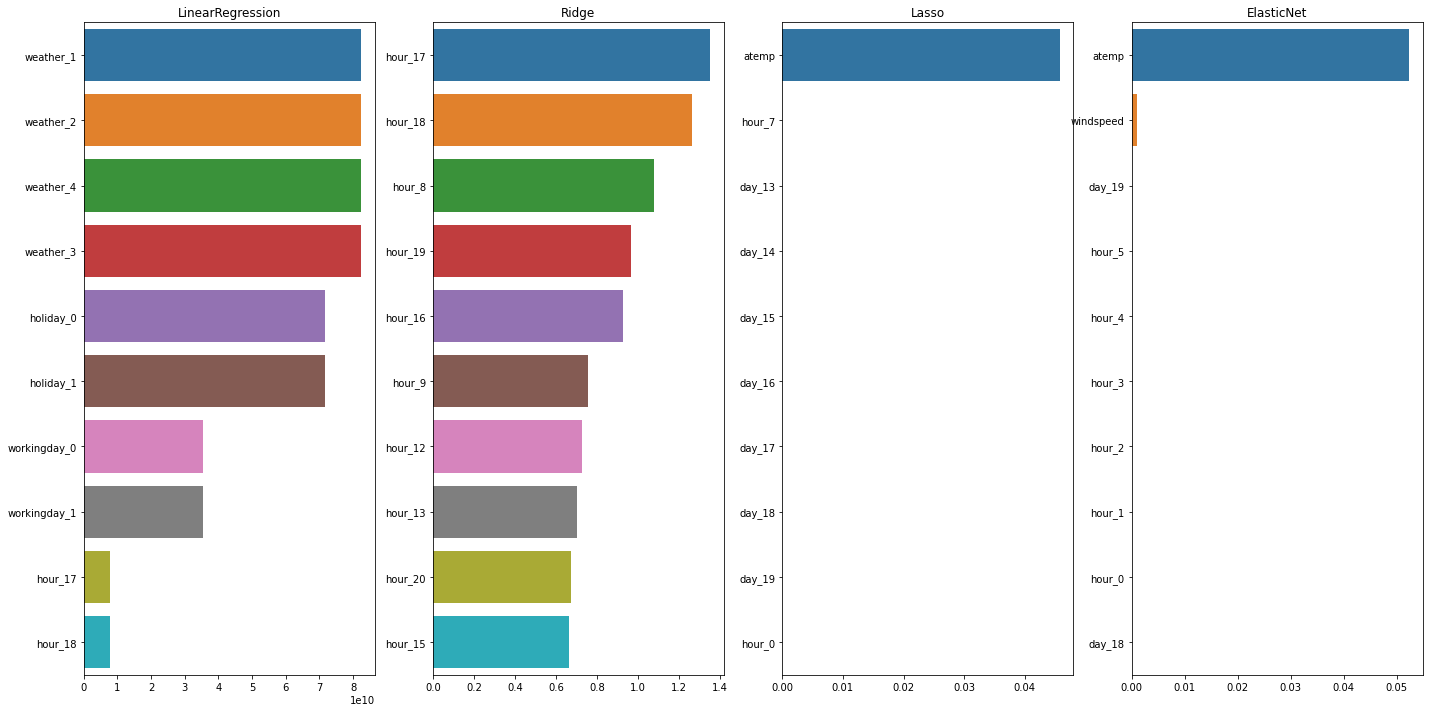

In [106]:

f, ax = plt.subplots(1,4,figsize=(24,12))
models = [lr, ridge, lasso, elastic]
for i, model in enumerate(models):
  coef = pd.Series(model.coef_, index=X.columns)
  coef = coef.sort_values(ascending=False)[:10]
  ax[i].set_title(model.__class__.__name__)
  sns.barplot(x=coef.values, y=coef.index, ax=ax[i])
  
plt.show()

회귀트리를 이용하여 예측

In [107]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf = RandomForestRegressor(n_estimators=1000)
gb = GradientBoostingRegressor(n_estimators=1000)
xgb = XGBRegressor(n_estimators=1000)
light = LGBMRegressor(n_esimators = 1000)

models = [rf, gb, xgb, light]
for model in models:
  get_model_predict(model, X_train, y_train, X_test, y_test, log=True)

#### RandomForestRegressor ####
RMSLE : 0.362, RMSE : 51.422, MSE : 2644.194, MAE : 31.759
#### GradientBoostingRegressor ####
RMSLE : 0.326, RMSE : 49.757, MSE : 2475.798, MAE : 30.874
[14:36:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#### XGBRegressor ####
RMSLE : 0.323, RMSE : 49.588, MSE : 2458.973, MAE : 30.759
#### LGBMRegressor ####
RMSLE : 0.334, RMSE : 51.596, MSE : 2662.164, MAE : 31.971


## 캐글에 제출

In [127]:
#drop 칼럼 수정
def drop_column(df):
  columns = ['datetime','season','temp','day']
  df = df.drop(columns, axis=1)
  return df

In [128]:
#전처리 함수 정리
def preprocessing(df, columns):
  df = get_date(df)
  df = drop_column(df)
  df = one_hot_encoding(df, columns)
  return df

In [129]:
#데이터 다시 로드
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [130]:
#데이터 전처리 
columns = ['holiday', 'workingday','weather','year','month','hour']
train = preprocessing(train, columns)
test = preprocessing(test, columns)

In [131]:
train = train.drop(['casual','registered'], axis=1)

In [132]:
#학습/타겟 데이터 분리
X = train.drop(['count'], axis=1)
y = np.log1p(train['count'])

xgb = XGBRegressor(n_estimators=1000)
xgb.fit(X, y)

[14:43:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

In [135]:
pred = xgb.predict(test)
pred = np.expm1(pred)

In [139]:
submission = pd.read_csv(sub_path)
submission['count'] = pred
submission.to_csv("xgb_model.csv", index=False)